# Neural style transfer
In this lab, we will be experimenting with Neural Style Transfer, i.e., transfering the style of a reference image to target image using gradient descent.

The code is based on the official Keras Neural Style Transfer example:

https://keras.io/examples/generative/neural_style_transfer/


## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The **total variation loss** imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The **style loss** is where the deep learning keeps in - that one is defined using a deep convolutional neural network. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations (i.e., feature maps) of the base image and the **style image**, extracted from different layers of a convnet (trained on ImageNet). The general idea is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The **content loss** is a L2 distance between the features of the base image (extracted from a deep layer) and the features of the **content image**, keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [121]:
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = "paris.jpg"
url = "https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/raw/main/F28w3Ac.jpeg"
urllib.request.urlretrieve(url,base_image_path)

style_reference_image_path ="starry_night.jpg"
url = "https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/raw/main/9ooB60I.jpeg"
urllib.request.urlretrieve(url,style_reference_image_path)

result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 224
img_ncols = int(width * img_nrows / height)

## Let's take a look at our base (content) image and our style reference image


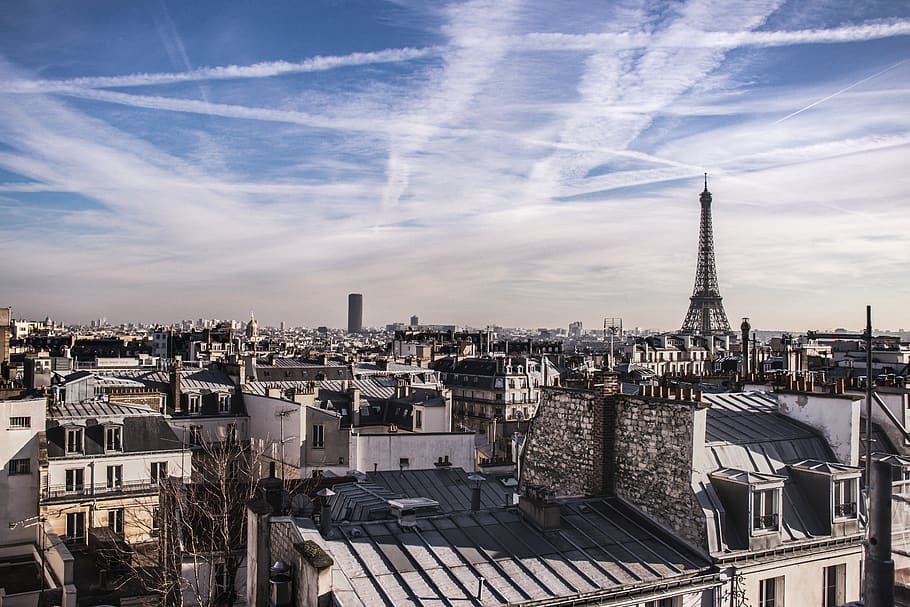

In [122]:
from IPython.display import Image, display

display(Image(base_image_path))


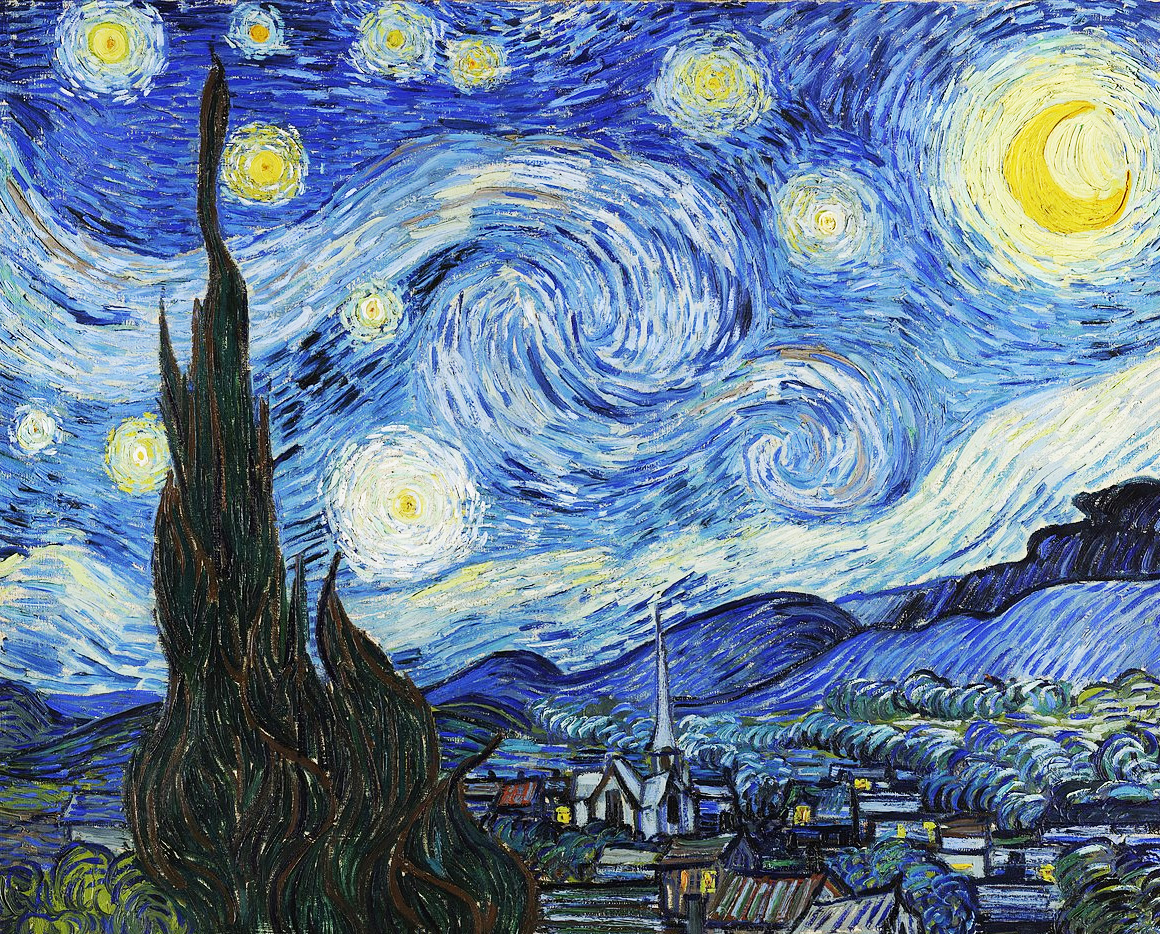

In [123]:
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities


In [124]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def get_noise_image(image_path):
    # Generate an image (same shape and type as image_path)
    # with random pixel intensities
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    t = img.dtype

    # Create noise image with same shape and type as img
    img = np.random.uniform(low=40,high=215,size=img.shape)
    img = img.astype(t)
    img = vgg19.preprocess_input(img)

    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


In [125]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [126]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Finally, here's the code that computes the style transfer loss.


In [127]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    loss_content = loss

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss_style = loss - loss_content # Isolate style loos contribution

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    loss_total_variation = loss - loss_style # Isolate TV loss contribution

    return loss, loss_content, loss_style, loss_total_variation

## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [128]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, loss_content, loss_style, loss_total_variation = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, loss_content, loss_style, loss_total_variation

## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


In [129]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 201 # set higher to improve results
for i in range(1, iterations + 1):
    loss, grads, loss_content, loss_style, loss_total_variation = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f loss_content=%.2f loss_style=%.2f loss_total_variation=%.2f" % (i, loss, loss_content, loss_style, loss_total_variation))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 10: loss=27575.27 loss_content=10.40 loss_style=13968.51 loss_total_variation=13606.76
Iteration 20: loss=20645.44 loss_content=13.87 loss_style=11118.68 loss_total_variation=9526.76
Iteration 30: loss=18137.21 loss_content=15.64 loss_style=10013.40 loss_total_variation=8123.81
Iteration 40: loss=16780.11 loss_content=16.82 loss_style=9409.13 loss_total_variation=7370.98
Iteration 50: loss=15900.70 loss_content=17.57 loss_style=8993.48 loss_total_variation=6907.22
Iteration 60: loss=15289.66 loss_content=18.09 loss_style=8697.96 loss_total_variation=6591.70
Iteration 70: loss=14832.98 loss_content=18.42 loss_style=8467.93 loss_total_variation=6365.05
Iteration 80: loss=14474.47 loss_content=18.67 loss_style=8280.87 loss_total_variation=6193.60
Iteration 90: loss=14180.81 loss_content=18.84 loss_style=8124.10 loss_total_variation=6056.71
Iteration 100: loss=13936.12 loss_content=19.01 loss_style=7989.84 loss_total_variation=5946.28
Iteration 110: loss=13722.75 loss_content=19.

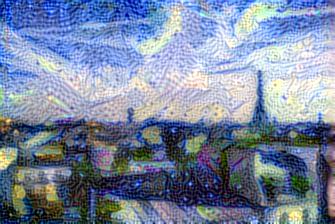

In [10]:
id = iterations-1
display(Image(result_prefix + f"_at_iteration_{id}.png"))

## Tasks

1. What happens to the output image if you set `style_weight=0`? Explain what you see.
2. Intuitively, you should expect to see a pure style image if you set `content_weight=0`. However, this wont work as expected, the reason being that the optimization is initialized with `base_image = preprocess_image(base_image_path)`. See if you can figure out a way to initialize the optimization with a random image, then run the optimization with `content_weight=0`. That should give you a pure style image.
3. Experiment with the total variation loss. Higher values of total_variation_weight should produce output images that are piecewise constant. Why?

## Solution

**Task 1:**

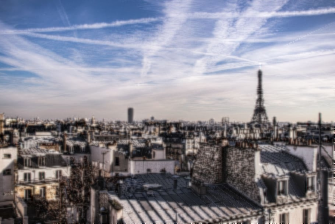

In [36]:
# Result of setting setting style_weight = 0
id = iterations-1
display(Image(result_prefix + f"_at_iteration_{id}.png"))

**Explanation:** Setting `style_weight=0` should result in a generated image that matches the content image. Which is what we see.

**Task 2:**

For this task, I define

```
def get_noise_image(image_path):
    # Generate an image (same shape and type as image_path)
    # with random pixel intensities
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    t = img.dtype

    # Create noise image with same shape and type as img
    img = np.random.uniform(low=40,high=215,size=img.shape)
    img = img.astype(t)
    img = vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)
```

and then I set

```
base_image = get_noise_image(base_image_path)
combination_image = tf.Variable(base_image)
```

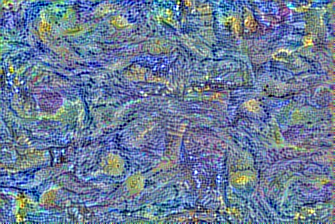

In [77]:
# Result of setting setting content_weight = 0
id = iterations-1
display(Image(result_prefix + f"_at_iteration_{id}.png"))

**Explanation:** The result is not perfect, but if you train for longer, it should become better (e.g., `iterations = 2001`).

**Task 3:**
For this task I found that it was not enought to jstu increase `total_variation_weight`. I also had to decrease `style_weight`.

I used:
```
total_variation_weight = 5e-5#1e-6
style_weight = 1e-7
content_weight = 2.5e-8
```

As expected the reconstructed image is more piece-wise constant than before.

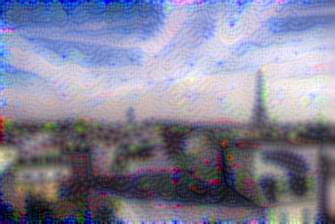

In [130]:
# Result of setting setting style_weight = 0
id = iterations-1
display(Image(result_prefix + f"_at_iteration_{id}.png"))